In [247]:
import pandas as pd
import logging
import numpy as np
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')
nltk.download('stopwords')  # download stopwords if necessary
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Surface\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Surface\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Surface\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Surface\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Surface\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load data from Kaggle
[Link to English Word Frequency Dataset](https://www.kaggle.com/datasets/rtatman/english-word-frequency) on Kaggle

In [248]:
english_words = pd.read_csv('data/english-words-freq.csv')
print(english_words.head())

  word        count
0  the  23135851162
1   of  13151942776
2  and  12997637966
3   to  12136980858
4    a   9081174698


# Load in Rap Lyrics data
This is the data set we scraped ourselves

In [249]:
rap_words = pd.read_csv('data/rap-words-freq.csv')
# rename the word column into index and index into word
rap_words.rename(columns={'word': 'index', 'index': 'word'}, inplace=True)
# drop the index column
rap_words = rap_words.drop(columns=['index'])
print(rap_words.head())

# load in swearwords
swearwords_data = pd.read_csv("data/bad-words.csv")
# rename jigaboo column into 'swearword'
swearwords_data.rename(columns={'jigaboo': 'swearword'}, inplace=True)

     word  count  swearword
0     and   1978      False
1    they    912      False
2  wishin     30      False
3      on   1903      False
4      me   2294      False


# Clean up the data and apply preprocessing

In [250]:
# create a set of stopwords
stop_words = set(stopwords.words('english'))
# lemmatize the words
lemmatizer = WordNetLemmatizer()
# legal english words
word_list = set(words.words())

def preprocess(df, is_rap=False):
    df['word'] = df['word'].astype(str)
    if not is_rap:
        print(df.head())
        # remove all words that are not in the english word list from the english words df
        df = df[df['word'].apply(lambda x: x.lower() in word_list)]

    # lemmatize the words
    df['word'] = df['word'].apply(lambda x: lemmatizer.lemmatize(x))

    # group by base words and sum the counts
    df = df.groupby('word', as_index=False)['count'].sum()

    # classify as swearword or not
    df['is_swearword'] = df['word'].isin(swearwords_data['swearword'])

    # calculate relative frequency: important first calculate frequency, then remove stopwords, otherwise alter distribution
    N = df['count'].sum()
    df['freq'] = df['count'] / N

    # remove stopwords from the 'words' column
    df = df[~df['word'].isin(stop_words)]

    # censor swearwords:
    df.loc[df['is_swearword'], 'word'] = df.loc[df['is_swearword'], 'word'].apply(lambda x: re.sub('[aeiouAEIOU]', '*', x))

    return df

In [251]:
english_words = preprocess(english_words)
rap_words = preprocess(rap_words, is_rap=True)

  word        count
0  the  23135851162
1   of  13151942776
2  and  12997637966
3   to  12136980858
4    a   9081174698


C:\Users\Surface\AppData\Local\Temp\ipykernel_11796\3501065271.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word'] = df['word'].apply(lambda x: lemmatizer.lemmatize(x))


# Exploratory Data Analysis
1. Create a plot showing the frequency of the top 10 most common words in the English language and how frequent they are in rap lyrics and vice versa

In [252]:
# 1.
def plot_top_n(n):
    # sort the english words by frequency and get the top 10
    english_top_n = english_words.sort_values(by='freq', ascending=False).head(n)
    rap_top_n = rap_words.sort_values(by='freq', ascending=False).head(n)
    # fetch the frequency of the top 10 words in the other case
    english_top_n = english_top_n.merge(rap_words[['word', 'count','freq']], on='word', suffixes=('', '_rap'))
    rap_top_n = rap_top_n.merge(english_words[['word', 'count','freq']], on='word', suffixes=('', '_english'))
    print('---ENGLISH---')
    print(english_top_n.head())
    print('---RAP---')
    print(rap_top_n.head())

    # use sns to create two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 20))
    # plot a bar plot on ax1, not stacked, of freq and rap_freq
    english_top_n.plot.bar(x='word', y=['freq', 'freq_rap'], ax=ax1, stacked=False)
    # set the x axis label to 'Word'
    ax1.set_xlabel('Word')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.legend(['Frequency', 'Frequency Rap'])
    # format the y axis to be a percentage with 2 decimal places
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.1%}".format(x)))
    ax1.set_title(f'English Top {n} Most Common Words, compared to Rap')
    # plot a bar plot on ax2, not stacked, of freq and english_freq
    rap_top_n.plot.bar(x='word', y=['freq', 'freq_english'], ax=ax2, stacked=False)
    ax2.set_xlabel('Word')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    ax2.legend(['Frequency', 'Frequency English'])
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.1%}".format(x)))
    ax2.set_title(f'Rap Top {n} Most Common Words, compared to English')
    # set the title for the entire figure
    fig.suptitle(f'Comparison of Top {n} Most Common Words')
    plt.show()


---ENGLISH---
   word       count  is_swearword      freq  count_rap  freq_rap
0   new  1551258643         False  0.003424        186  0.001196
1    wa  1518293694         False  0.003351        367  0.002360
2     u  1408728209         False  0.003110        158  0.001016
3  home  1276852170         False  0.002818         40  0.000257
4  time  1111656450         False  0.002454        287  0.001846
---RAP---
    word  count  is_swearword      freq  count_english  freq_english
0   yeah   1983         False  0.012753       25858426      0.000057
1   like   1740         False  0.011190      520585287      0.001149
2    got   1344         False  0.008643      145057782      0.000320
3  b*tch   1035          True  0.006656        8302447      0.000018
4   dont   1020         False  0.006560       20071832      0.000044


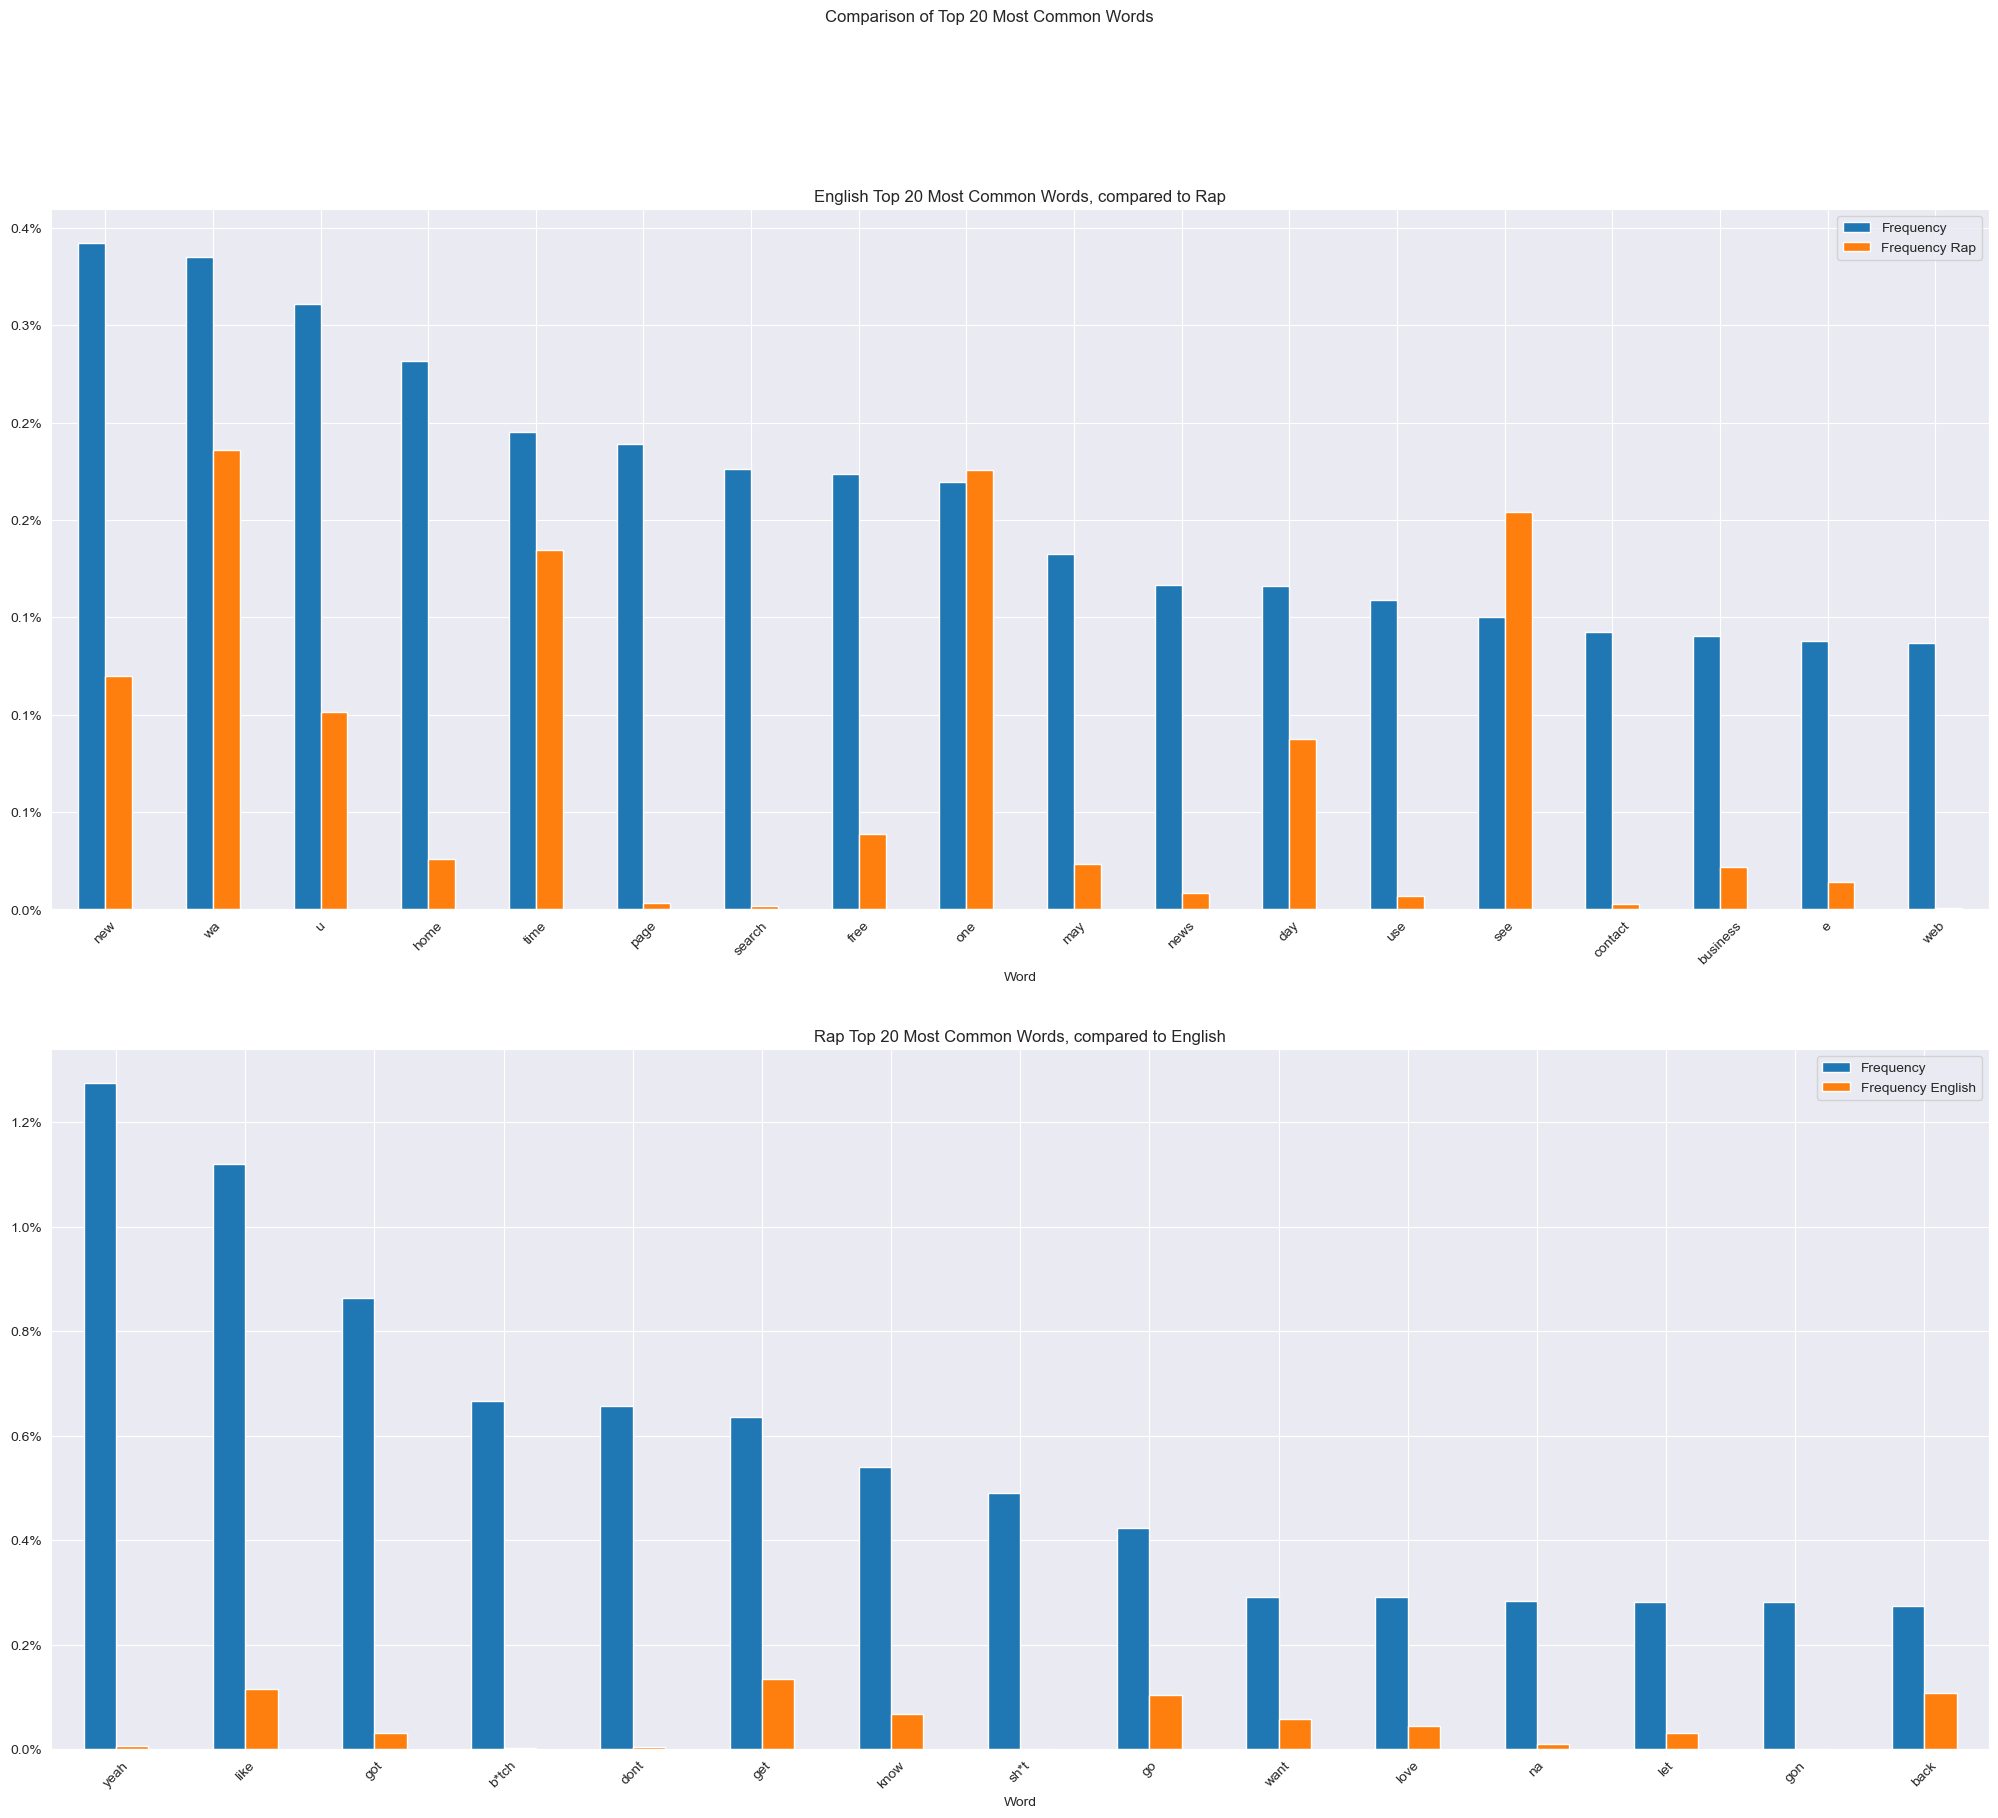

In [253]:
plot_top_n(20)